In [56]:
import random
import torch
import torch.nn.functional as F

words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
s_to_i = {s: i + 1 for i, s in enumerate(chars)}
i_to_s = {i + 1: s for i, s in enumerate(chars)}
s_to_i['.'] = 0
i_to_s[0] = '.'
block_size = 8
vocab_size = len(i_to_s)
print(f"vocab_size: {vocab_size}")


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = s_to_i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"x.shape is {X.shape}, y.shape is {Y.shape}")
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

vocab_size: 27
x.shape is torch.Size([182625, 8]), y.shape is torch.Size([182625])
x.shape is torch.Size([22655, 8]), y.shape is torch.Size([22655])
x.shape is torch.Size([22866, 8]), y.shape is torch.Size([22866])


In [64]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.runnning_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.runnning_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.runnning_var = (1 - self.momentum) * self.runnning_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]


class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []


class Sequence:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [43]:
torch.manual_seed(42)

In [68]:
n_embd = 10
n_hidden = 68

layers = [
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

model = Sequence(layers)

with torch.no_grad():
    model.layers[-1].weight *= 0.1

params = model.parameters()
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

22397


In [66]:
ix = torch.randint(0, Xtrain.shape[0], (4,))
Xb, Yb = Xtrain[ix], Ytrain[ix]
logits = model(Xb)
print(logits.shape)

torch.Size([4, 27])


In [67]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [69]:
max_steps = 200000
batch_size = 32
lossi = []

for k in range(max_steps):
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    # forward
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in params:
        p.grad = None
    loss.backward()

    lr = 0.1 if k < 150000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if k % 10000 == 0:
        print(f"Epoch: {k}/{max_steps}, loss: {loss.item():}")
    lossi.append(loss.log10().item())
    # if k > 1000:
    #     break

Epoch: 0/200000, loss: 3.2844667434692383
Epoch: 10000/200000, loss: 2.5723860263824463
Epoch: 20000/200000, loss: 1.9913899898529053
Epoch: 30000/200000, loss: 2.1509008407592773
Epoch: 40000/200000, loss: 1.953590750694275
Epoch: 50000/200000, loss: 1.745354413986206
Epoch: 60000/200000, loss: 2.356311321258545
Epoch: 70000/200000, loss: 2.2894539833068848
Epoch: 80000/200000, loss: 2.5563747882843018
Epoch: 90000/200000, loss: 2.178837537765503
Epoch: 100000/200000, loss: 2.2237842082977295
Epoch: 110000/200000, loss: 2.0635805130004883
Epoch: 120000/200000, loss: 1.7373707294464111
Epoch: 130000/200000, loss: 2.327842950820923
Epoch: 140000/200000, loss: 2.253471612930298
Epoch: 150000/200000, loss: 2.038799285888672
Epoch: 160000/200000, loss: 1.9581204652786255
Epoch: 170000/200000, loss: 1.807316780090332
Epoch: 180000/200000, loss: 2.084141969680786
Epoch: 190000/200000, loss: 2.1532721519470215


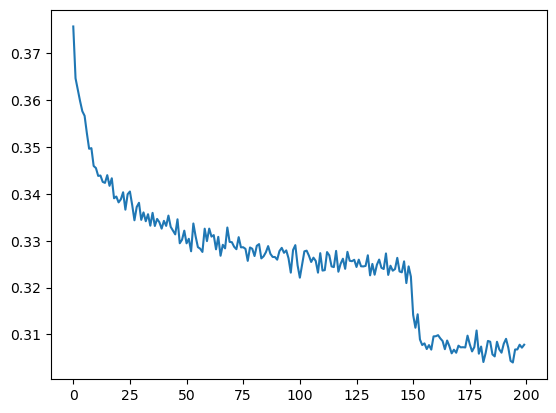

In [52]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [72]:
for layer in model.layers:
    layer.training = False

In [70]:
@torch.no_grad()
def get_split_loss(split):
    dataset = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }
    x, y = dataset[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss is {loss.item()}")


get_split_loss("train")
get_split_loss("dev")

train loss is 1.940340518951416
dev loss is 2.0246174335479736


In [73]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(i_to_s[i] for i in out))  # decode and print the generated word

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0